In [1]:
import climt
import numpy as np
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
from metpy.units import units
from scipy.interpolate import interp2d, RectBivariateSpline

%matplotlib inline

In [2]:
radiation = climt.RRTMGLongwave(cloud_overlap_method='clear_only')

lats = np.linspace(-90, 90, 50)
state = climt.get_default_state([radiation], x={}, 
                y={'label' : 'latitude', 'values': lats, 'units' : 'degress N'},
                mid_levels={'label' : 'mid_levels', 'values': np.arange(30), 'units' : ''},
                interface_levels={'label' : 'interface_levels', 'values': np.arange(31), 'units' : ''}
                )

T_surf = np.linspace(250, 350, len(lats)) * units('K')
pressures = state['air_pressure'].values[0] * units('Pa')

T = np.zeros(state['air_temperature'].values[0].shape) * units('K')

T[:, 0] = T_surf

print('Calculating moist adiabats...')
for i in range(T.shape[0]):
    if i%10 == 0: print(i)
    T[i, :] = mpcalc.moist_lapse(temperature=T[i,0], pressure=pressures[i])
print('done')

state['surface_temperature'].values[:] = T_surf
state['air_temperature'].values[:] = T

print('Running CliMT radiation code...')
tendencies, diagnostics = radiation(state)
print('done')

Calculating moist adiabats...
0
10
20
30
40
done
Running CliMT radiation code...
done


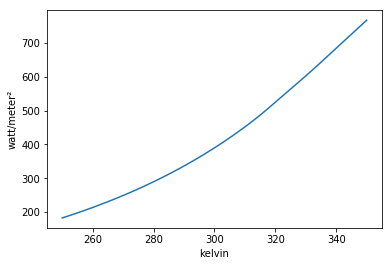

In [3]:
OLR = diagnostics['upwelling_longwave_flux_in_air_assuming_clear_sky']
olr_toa = OLR.sel(interface_levels=30).values[0] * units('W/m^2')
plt.plot(T_surf, olr_toa)

In [4]:
N = 25

p = pressures[0]
T = np.zeros((N, len(p))) * units('K')

T[:, 0] = np.linspace(250, 350, N) * units('K')

print('Calculating moist adiabats...')
for i in range(N):
    if i%10 == 0: print(i)
    T[i, :] = mpcalc.moist_lapse(temperature=T[i, 0], pressure=p)
print('done')

Calculating moist adiabats...
0
10
20
done


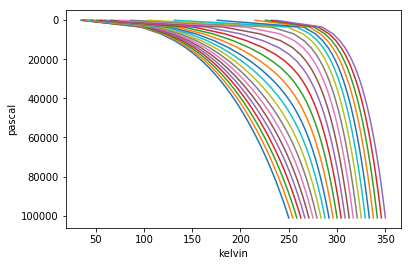

In [5]:
for i in range(N):
    plt.plot(T[i,:], p)
plt.gca().invert_yaxis()

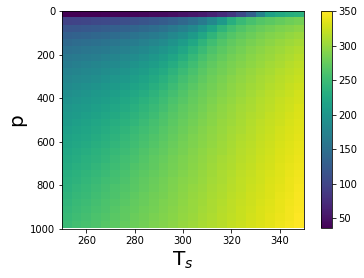

In [6]:
plt.imshow(T.T, origin='lower', #interpolation='hermite'
          extent=(250,350,1000,0), aspect=0.09)
plt.xlabel('T$_s$', size=20)
plt.ylabel('p', size=20)
plt.colorbar()

In [7]:
x = T[:, 0]
y = p
z = T.T

f = interp2d(x, y, z)

In [8]:
# plt.plot(f(300, p))
# plt.gca().invert_yaxis()

i = 12
interpT = f(x[i], p) * units('K')
interpT = np.flip(interpT, 0)
Ti = np.reshape(T[i, :], (30,1))

print(np.max(np.abs(Ti - interpT)))

0.0 kelvin


In [9]:
Tsurf = (305 - 35/90*np.abs(lats))
pres = p.magnitude

print(f(Tsurf, pres)[:,0])

[  38.65778656  107.05482745  129.9642295   145.7225      158.09374614
  168.42853744  177.38288571  185.32983187  192.50320434  199.05935968
  205.10753408  210.72634376  215.97347946  220.89184841  225.51372725
  229.86376526  233.96125123  237.82187232  241.45906788  244.88501134
  248.11128385  251.14926073  254.01026853  256.70559988  259.24642859
  261.64368001  263.90789903  266.04914055  268.07688903  270.        ]


In [155]:
# lats = np.arange(-90, 90, 0.5)

""" FULL BLOWN """
radiation = climt.RRTMGLongwave(cloud_overlap_method='clear_only')
state = climt.get_default_state([radiation], x={}, 
                y={'label' : 'latitude', 'values': lats, 'units' : 'degress N'},
                mid_levels={'label' : 'mid_levels', 'values': np.arange(30), 'units' : ''},
                interface_levels={'label' : 'interface_levels', 'values': np.arange(31), 'units' : ''}
                )

# samples = 100
# pressures = state['air_pressure'].values[0, 0, :] * units('Pa')
# Tsample = np.linspace(250, 350, samples) * units('K')
# Tdata = np.zeros((samples, len(pressures))) * units('K')
# Tdata[:, 0] = Tsample

# print('Calculating moist adiabats...')
# for i in range(samples):
#     if i%10 == 0: print(i)
#     Tdata[i, :] = mpcalc.moist_lapse(temperature=Tdata[i, 0], pressure=pressures)
# print('done')

# interpolated_moist_adiabat_f = interp2d(pressures, Tsample, Tdata)

def L(T):
    state['surface_temperature'].values[:] = T
    Tvals = np.zeros(state['air_temperature'].values[0].shape) * units('K')
    for i in range(len(lats)):
        state['air_temperature'].values[0, i, :] = np.flip(interpolated_moist_adiabat_f(pressures, T[i]), axis=0)
    tendencies, diagnostics = radiation(state)
    return diagnostics['upwelling_longwave_flux_in_air_assuming_clear_sky'].sel(interface_levels=30).values[0]

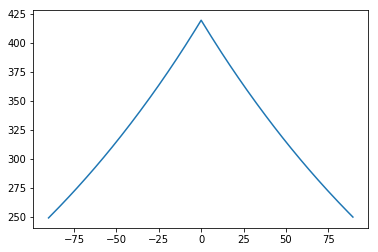

In [156]:
T = (305 - 35/90*np.abs(lats))
OLR = L(T)
plt.plot(lats, OLR)

In [159]:
state['surface_longwave_emissivity']

<xarray.DataArray (longitude: 1, latitude: 360, num_longwave_bands: 16)>
array([[[ 1.,  1., ...,  1.,  1.],
        [ 1.,  1., ...,  1.,  1.],
        ..., 
        [ 1.,  1., ...,  1.,  1.],
        [ 1.,  1., ...,  1.,  1.]]])
Coordinates:
  * longitude           (longitude) float64 0.0
  * latitude            (latitude) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ...
  * num_longwave_bands  (num_longwave_bands) int64 0 1 2 3 4 5 6 7 8 9 10 11 ...
Attributes:
    units:    dimensionless

In [10]:
for i in state.keys():
    print(i)

y
air_pressure
num_longwave_bands
surface_longwave_emissivity
mole_fraction_of_nitrous_oxide_in_air
longwave_optical_thickness_due_to_cloud
mole_fraction_of_ozone_in_air
x
mole_fraction_of_oxygen_in_air
mole_fraction_of_carbon_dioxide_in_air
cloud_area_fraction_in_atmosphere_layer
surface_temperature
mole_fraction_of_cfc22_in_air
interface_levels
latitude
mass_content_of_cloud_liquid_water_in_atmosphere_layer
time
mole_fraction_of_carbon_tetrachloride_in_air
mass_content_of_cloud_ice_in_atmosphere_layer
cloud_ice_particle_size
mole_fraction_of_cfc11_in_air
air_temperature
air_pressure_on_interface_levels
mole_fraction_of_cfc12_in_air
mole_fraction_of_methane_in_air
specific_humidity
longitude
cloud_water_droplet_radius
longwave_optical_thickness_due_to_aerosol
mid_levels


In [ ]:
print(state['surface_longwave_emissivity'])

In [ ]:
print(tendencies)

In [ ]:
print(diagnostics)

In [27]:
print(pressures[0])

[ 101117.36         97634.04827586   94150.73655172   90667.42482759   87184.11310345   83700.80137931   80217.48965517   76734.17793103   73250.8662069    69767.55448276   66284.24275862   62800.93103448   59317.61931034   55834.30758621   52350.99586207   48867.68413793   45384.37241379   41901.06068966   38417.74896552   34934.43724138   31451.12551724   27967.8137931    24484.50206897   21001.19034483   17517.87862069   14034.56689655   10551.25517241    7067.94344828    3584.63172414     101.32      ] pascal
